### A coding scheme for Simon game sequences

#### **Author:** Sol Markman (smarkman@mit.edu)

Assumption: This scheme is hierarchical, so that different chunk types take priority over others. For example, repeats of a single color are chunked first, then repeats of multiple colors, then nested repeats, and then alternations are chunked with the remaining items, etc.
- RRRGRGRG is compressed to [R]^3 [GR]^2 G, size=6
- RRRGRG is compressed to [R]^3 [GRG], size=4

#### Types of chunks/compression and their sizes:

#### 1) Repeats
Size = (size of subsequence) + 1. This assumes that size does not increase with the number of repeats, and 
repeats are only beneficial for size>2.

a) Single color repeats
- RRRR is compressed to [R]^4, size=2

b) Multicolor repeats
- RGRGRG is compressed to [RG]^3, size=3
    
c) Nested repeats
- RRRGGGRRRGGG is compressed to [ [R]^3 [G]^3 ]^2, size=5

#### 2) Alternations
Not yet implemented

#### 3) Cycles
Not yet implemented

#### 4) Exposure compression (within a sequence)
Not yet implemented


In [1]:
# Repeat chunking for hypotheses 1 (single repeats only) and 3 (+ multicolor and nested repeats).
def find_repeats(seq, length): 
    """
    Finds repeats of patterns of a fixed length.
    """
    i = 0
    result = []
    while i < len(seq):
        if i + 2 * length <= len(seq) and seq[i:i+length] == seq[i+length:i+2*length]:
            pattern = seq[i:i+length]
            count = 2
            j = i + 2 * length
            while j + length <= len(seq) and seq[j:j+length] == pattern:
                count += 1
                j += length
            result.append(f'[{pattern}]{count}')
            i = j

        else: # move onto the next character
            result.append(seq[i])
            i += 1

    return ''.join(result)

def repeat_chunking(seq, single_only=False): 
    '''
    Finds repeating patterns within a sequence recursively.
    If single_only, only simple single-character repeats.
    Otherwise, includes multicolor and nested repeats.
    Note: Shorter pattern lengths are chunked first. Once a character is chunked, that chunk cannot be broken.
        E.g. GBGBBB = GBG[B]3, not [GB]2[B]2 because the B's at the end are chunked first.
    '''
    length = 1 # Initialize pattern length
    max_len = 1

    # recursively look for repeating patterns of increasing length
    new_seq = seq
    while length <= max_len:
        new_seq = find_repeats(new_seq, length)
        max_len = 1 if single_only else len(new_seq)//2
        length += 1 # increase length and keep going

    code = ''.join(new_seq)
    code_len = len(code.replace('[', '').replace(']', ''))
    chunkability = 1 - code_len/len(seq)

    return code_len, chunkability, code

In [2]:
# coding scheme 1: chunking simple (single character) repeats only.
def hyp1(seq):
    return repeat_chunking(seq, single_only=True)

# Testing hyp1 code
test_sequences = ['BBBRRRYYYGGG', 'RRRZGZRRR', 'BBBBGRY', 'RRRYGYGYG', 'GBGBB', 
                    'BBBBBBBrrrBBBBBB', 'GGGGGGGG', 'ABCD', 'BGGGR', 'abbabbabba']
answers = [8, 7, 5, 8, 5, 6, 2, 4, 4, 10]

def test_coding_scheme(scheme, sequences, answers):
    for i in range(len(sequences)):
        s_idx = i
        sequence = sequences[s_idx]
        print(sequence, answers[s_idx])
        print(scheme(sequence))
        if scheme(sequence)[0] != answers[s_idx]:
            print('^ERROR')
    

test_coding_scheme(hyp1, test_sequences, answers)

BBBRRRYYYGGG 8
(8, 0.33333333333333337, '[B]3[R]3[Y]3[G]3')
RRRZGZRRR 7
(7, 0.2222222222222222, '[R]3ZGZ[R]3')
BBBBGRY 5
(5, 0.2857142857142857, '[B]4GRY')
RRRYGYGYG 8
(8, 0.11111111111111116, '[R]3YGYGYG')
GBGBB 5
(5, 0.0, 'GBG[B]2')
BBBBBBBrrrBBBBBB 6
(6, 0.625, '[B]7[r]3[B]6')
GGGGGGGG 2
(2, 0.75, '[G]8')
ABCD 4
(4, 0.0, 'ABCD')
BGGGR 4
(4, 0.19999999999999996, 'B[G]3R')
abbabbabba 10
(10, 0.0, 'a[b]2a[b]2a[b]2a')


In [3]:
# coding scheme 3: including complex repeats (multi-item and nesting).
def hyp3(seq):
    return repeat_chunking(seq, single_only=False)

# Testing hyp3 code
test_sequences = ['BBBRRRYYYGGG', 'RRRZGZRRR', 'BBBBGRY', 'RRRYGYGYG', 'GBGBB', 
                'BBBBBBBrrrBBBBBB', 'GRGRGRZDZDZDZTTTTTTTGGG', 'ababcdcdababcdcd',
                'abbabbabba', 'abcabcabc', 'abbccccabbccccabbcccc', 'bbbbaaaabbbbaaaa',
                'bbbaaabbbaaa', 'bbaabbaa', 'baba', 'bbaabbaab']
answers = [8, 7, 5, 5, 5, 6, 11, 7, 5, 4, 6, 5, 5, 5, 3, 6]

test_coding_scheme(hyp3, test_sequences, answers)

BBBRRRYYYGGG 8
(8, 0.33333333333333337, '[B]3[R]3[Y]3[G]3')
RRRZGZRRR 7
(7, 0.2222222222222222, '[R]3ZGZ[R]3')
BBBBGRY 5
(5, 0.2857142857142857, '[B]4GRY')
RRRYGYGYG 5
(5, 0.4444444444444444, '[R]3[YG]3')
GBGBB 5
(5, 0.0, 'GBG[B]2')
BBBBBBBrrrBBBBBB 6
(6, 0.625, '[B]7[r]3[B]6')
GRGRGRZDZDZDZTTTTTTTGGG 11
(11, 0.5217391304347826, '[GR]3[ZD]3Z[T]7[G]3')
ababcdcdababcdcd 7
(7, 0.5625, '[[ab]2[cd]2]2')
abbabbabba 5
(5, 0.5, '[a[b]2]3a')
abcabcabc 4
(4, 0.5555555555555556, '[abc]3')
abbccccabbccccabbcccc 6
(6, 0.7142857142857143, '[a[b]2[c]4]3')
bbbbaaaabbbbaaaa 5
(5, 0.6875, '[[b]4[a]4]2')
bbbaaabbbaaa 5
(5, 0.5833333333333333, '[[b]3[a]3]2')
bbaabbaa 5
(5, 0.375, '[[b]2[a]2]2')
baba 3
(3, 0.25, '[ba]2')
bbaabbaab 6
(6, 0.33333333333333337, '[[b]2[a]2]2b')


In [54]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [84]:
# Methods adapted from LempelZivScheme.ipynb

def parse_simon_game_csv(filepath):
    # Parse the CSV file and convert the color names to single characters
    dataframe = pd.read_csv(filepath)
    dataframe["Event"] = dataframe["Event"].map(
        {"red": "R", "blue": "B", "green": "G", "yellow": "Y", np.nan: "",
         "None": ""}
    )
    # Because there may be multiple gameplays in a single file,
    # we need to split the data frame whenever Score reset to 0.
    # Create a group id that increments each time Score is 0
    dataframe["group_id"] = (dataframe["Score"] == 0).cumsum()
    # Split the data into subdataframes based on group_id
    subdataframes = [group for _, group in dataframe.groupby("group_id")]
    game_results = dict()
    for data in subdataframes:
        # Get the longest chain the player was able to reproduce
        # and the chain they made when the made a mistake.
        best_and_last = data[data.Score >= max(data.Score) - 1]
        # print(best_and_last)
        longest_sequence = "".join(
            best_and_last[
                best_and_last.Score == best_and_last.iloc[0].Score
            ].Event.to_list()
        )
        mistake_sequence = "".join(
            best_and_last[
                best_and_last.Score == best_and_last.iloc[-1].Score
            ].Event.to_list()
        )
        # Discard only length-0 sequences as a result of player inattention.
        if len(longest_sequence) == 0:
            continue
        game_number = data.iloc[0].group_id
        # Dictionary containing the longest sequence and the mistake sequence
        game_sequences = {
            "longest_sequence": longest_sequence,
            "mistake_sequence": mistake_sequence,
        }
        game_results[game_number] = game_sequences
    return game_results


def parse_simons_game_logs(directory):
    session_data = {}
    # Traverse the directory tree
    for root, dirs, files in os.walk(directory):
        # Get all CSV files in the specified directory
        for file in files:
            if file.endswith(".csv"):
                filepath = os.path.join(root, file)
                filename = os.path.basename(filepath)
                game_sequences = parse_simon_game_csv(filepath)
                session_data[filename] = (
                    game_sequences
                )
    return session_data

In [74]:
# Analyze data within one subject

def get_chunkabilities_from_logs(data_path):
    session_data = parse_simons_game_logs(data_path)

    N_games = 0
    scores = []
    sequences = []

    for i, key in enumerate(session_data.keys()):
        N_games += len(session_data[key])
        for game in session_data[key].values():
            sequences.append(game['longest_sequence'])
            scores.append(len(game['longest_sequence']))

    print('Games: ', N_games)
    print('Scores: ', scores)
    print('Sequences: ', sequences)

    # Compute chunkabilities for each sequence
    chunk1 = []
    chunk3 = []
    for seq in sequences:
        chunk1.append(hyp1(seq)[1])
        chunk3.append(hyp3(seq)[1])
    
    return scores, sequences, chunk1, chunk3

Games:  3
Scores:  [12, 21, 25]
Sequences:  ['GRRBBYYBBYBY', 'YGGYGGGGYRRGBRBYBBRBG', 'BGGBGGGBYYBGYBBBBBGGYBBYB']
Hyp:   slope,   intercept,   r-value,   p-value,   std_err
Hyp1:  82.23954443614637 12.336445108289766 0.9940674563975155 0.06937939845650898 8.998191508701137
Hyp3:  82.23954443614637 12.336445108289766 0.9940674563975155 0.06937939845650898 8.998191508701137


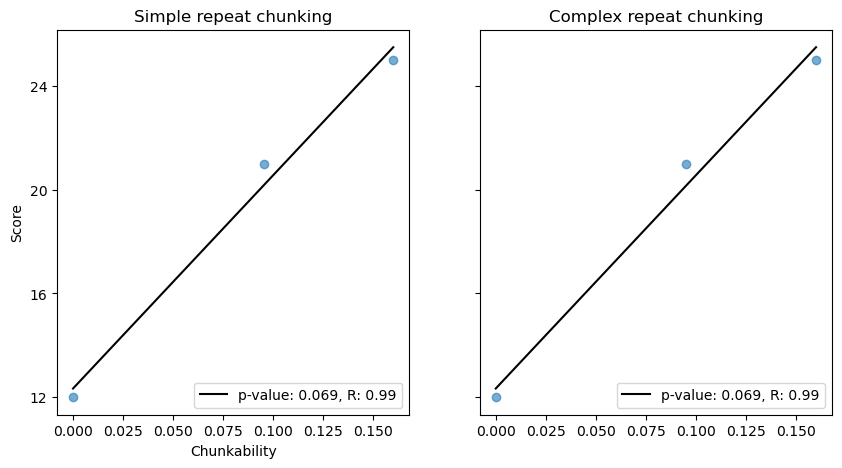

In [86]:
data_path = './Hokyung_logs' #'./Quilee_logs' #'./Jack_logs' # './Sol_logs/Random' # 
scores, sequences, chunk1, chunk3 = get_chunkabilities_from_logs(data_path)

m1, b1, r1, p1, std_err1 = stats.linregress(chunk1, scores)
m3, b3, r3, p3, std_err3 = stats.linregress(chunk3, scores)

print('Hyp:   slope,   intercept,   r-value,   p-value,   std_err')
print('Hyp1: ', m1, b1, r1, p1, std_err1)
print('Hyp3: ', m3, b3, r3, p3, std_err3)

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].scatter(chunk1, scores, alpha=0.6)
ax[1].scatter(chunk3, scores, alpha=0.6)
ax[0].set(xlabel='Chunkability', ylabel='Score', title='Simple repeat chunking',
          yticks=np.arange(0, np.max(scores)+1, 4))
ax[1].set(title='Complex repeat chunking')
ax[0].plot(np.array(chunk1), m1*np.array(chunk1) + b1, color='k', zorder=0, 
           label=f'p-value: {p1:.3f}, R: {r1:.2f}')
ax[1].plot(np.array(chunk3), m3*np.array(chunk3) + b3, color='k', zorder=0, 
           label=f'p-value: {p3:.3f}, R: {r3:.2f}')
ax[0].legend(loc='lower right')
ax[1].legend(loc='lower right')
